# Imports

In [90]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2

### checking for device 

In [91]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Image preprocessing

In [92]:

transformer=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize((0.5, ), (0.5, ))
])

### Dataloader 

In [93]:
#Path for training and testing directory
train_path='C:/Users/hrishikesh/Desktop/brain-tumor/train'
test_path='C:/Users/hrishikesh/Desktop/brain-tumor/test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

### classes 

In [94]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [95]:
print(classes)

['no', 'yes']


### Building CNN model 

In [96]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (64,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (64,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (64,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (64,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (64,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (64,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (64,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (64,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (64,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (64,32,75,75)
        
        
        self.fc=nn.Linear(in_features=112 * 112 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (64,32,75,75)
            
        output=output.view(-1,32*112*112)
            
            
        output=self.fc(output)
            
        return output
            
        


In [97]:
model=ConvNet(num_classes=2).to(device)

### Optmizer and loss function 

In [98]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [99]:
num_epochs=50

In [100]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [101]:
print(train_count,test_count)

137 60


### Model training and saving best model 

In [102]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    
       


Epoch: 0 Train Loss: tensor(31.91360) Train Accuracy: 0.583941605839416 Test Accuracy: 0.5
Epoch: 1 Train Loss: tensor(25.40189) Train Accuracy: 0.7153284671532847 Test Accuracy: 0.5333333333333333
Epoch: 2 Train Loss: tensor(23.19349) Train Accuracy: 0.6934306569343066 Test Accuracy: 0.6166666666666667
Epoch: 3 Train Loss: tensor(13.37885) Train Accuracy: 0.8467153284671532 Test Accuracy: 0.5666666666666667
Epoch: 4 Train Loss: tensor(17.84257) Train Accuracy: 0.8175182481751825 Test Accuracy: 0.65
Epoch: 5 Train Loss: tensor(4.11926) Train Accuracy: 0.9051094890510949 Test Accuracy: 0.5333333333333333
Epoch: 6 Train Loss: tensor(1.97488) Train Accuracy: 0.948905109489051 Test Accuracy: 0.5333333333333333
Epoch: 7 Train Loss: tensor(1.00259) Train Accuracy: 0.948905109489051 Test Accuracy: 0.55
Epoch: 8 Train Loss: tensor(0.88372) Train Accuracy: 0.9635036496350365 Test Accuracy: 0.55
Epoch: 9 Train Loss: tensor(0.37737) Train Accuracy: 0.9854014598540146 Test Accuracy: 0.616666666666

### Visualising the model results 

In [103]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

In [104]:
img = np.transpose(images[2].numpy(), (1, 2, 0)).squeeze(axis=2)

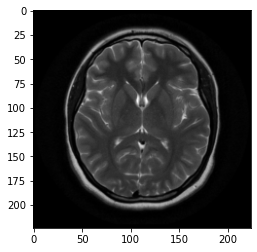

In [105]:
plt.imshow(img,cmap='gray')

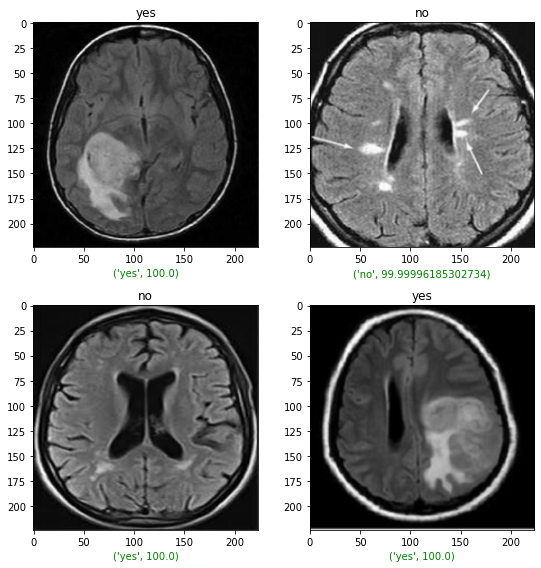

In [106]:
import random
plt.figure(figsize=(8,8))
for i in range(1,5):
    ax = plt.subplot(2,2,i)
    random_index = random.randrange(0,31)
    img = np.transpose(images[random_index].numpy(), (1, 2, 0)).squeeze(axis=2)
    T = transforms.ToPILImage()
    img_t = T(images[random_index])
    img_t = transformer(img_t)
    batch_t = torch.unsqueeze(img_t, 0)
    out = model(batch_t)
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    pred = classes[index[0]], percentage[index[0]].item()
    plt.imshow(img,cmap='gray')
    plt.title(classes[labels[random_index]])
    plt.xlabel(pred,color='green')
    plt.tight_layout()

### downloading yolov5 model with our custom weights

In [107]:
cus_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp2/weights/last.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\hrishikesh/.cache\torch\hub\master.zip
YOLOv5  2022-3-30 torch 1.11.0 CPU

Fusing layers... 
Model summary: 213 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


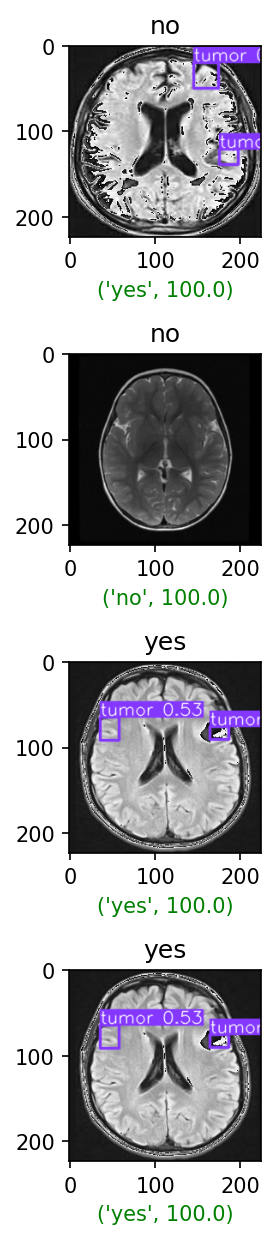

In [113]:
import random
plt.figure(figsize=(10,10),dpi=150)
for i in range(1,5):
    ax = plt.subplot(5,1,i)
    random_index = random.randrange(0,31)
    img = np.transpose(images[random_index].numpy(), (1, 2, 0)).squeeze(axis=2)
    T = transforms.ToPILImage()
    img_t = T(images[random_index])
    img_t = transformer(img_t)
    batch_t = torch.unsqueeze(img_t, 0)
    out = model(batch_t)
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    pred = classes[index[0]], percentage[index[0]].item()
    if pred[0] == 'no':
        plt.imshow(img,cmap='gray')
    else:
        img = np.transpose(images[random_index].numpy())
        T = transforms.ToPILImage()
        img_t = T(images[random_index])
        result = cus_model(img_t)
        plt.imshow(np.squeeze(result.render()))
    plt.title(classes[labels[random_index]])
    plt.xlabel(pred,color='green')
    plt.tight_layout()


In [114]:
img = 'test/yes/Y20.jpg'

In [115]:
result = cus_model(img)

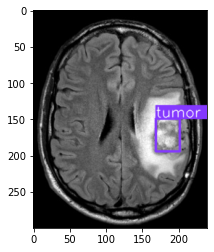

In [116]:
%matplotlib inline
plt.imshow(np.squeeze(result.render()))
plt.show()